# Mise en pratique de `Spark SQL` 


- Qu'est-ce que Spark SQL ?

For SQL users, Spark SQL provides state-of-the-art SQL performance and maintains compatibility with Shark/Hive. In particular, like Shark, Spark SQL supports all existing Hive data formats, user-defined functions (UDF), and the Hive metastore.

For Spark users, Spark SQL becomes the narrow-waist for manipulating (semi-) structured data as well as ingesting data from sources that provide schema, such as JSON, Parquet, Hive, or EDWs. It truly unifies SQL and sophisticated analysis, allowing users to mix and match SQL and more imperative programming APIs for advanced analytics.

For open source hackers, Spark SQL proposes a novel, elegant way of building query planners. It is incredibly easy to add new optimizations under this framework.

Internally, a structured query is a Catalyst tree of (logical and physical) relational operators and expressions.

- Importer les modules usuels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, timeit
from pathlib import Path
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)

- Importer les classes et fonctions importées par `pyspark` pendant la session.

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col
import pyspark.sql.functions as fn
from pyspark.sql.catalog import Catalog
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

- Démarrer la `SparkSession`

In [3]:
conf = SparkConf().setAppName("Spark SQL Illustration")
sc = SparkContext(conf=conf)

spark = (SparkSession
    .builder
    .appName("Spark SQL")
    .getOrCreate()
)

Common Voice Finnish
======================

Description : Un ensemble de jeux de données au sujet des métadonnées des audios enregistrés en finnois. Les participants sont volontaires à contribuer leur voix en lisant les phrases distribuées aléatoirement. En général, chaque fichier audio contient une phrase.

**Source** : [Common Voice FI]('https://commonvoice.mozilla.org/fi/datasets')

**Structure des données** : les fichiers se composent de 6 fichiers avec 10 colonnes.

```
|-- client_id (nullable = true)
    |-- path (nullable = true)
    |-- sentence (nullable = true)
    |-- up_votes (nullable = true)
    |-- down_votes (nullable = true)
    |-- age (nullable = true)
    |-- gender (nullable = true)
    |-- accent (nullable = true)
    |-- locale (nullable = true)
    |-- segment (nullable = true)
```

Chaque colonne correspond à une information: l'identifiant du client, le chemin du fichier audio, la phrase, le nombre de votes pour, le nombre de votes contre, l'âge, le genre, l'accent, le lieu et le segment.

Exemple:

| client_id | path | sentence | up_votes | down_votes | age | gender | accent | locale | segment
|:----|:----|:----|:----|:----|:----|:----|:----|:----|:----|
|2ebf0d7f2db234c72eaf994| common_voice_fi_24001101.mp3| Mysteerimies oli oppinut moraalinsa taruista, elokuvista ja peleistä. |2|0||||fi||
|c9195a7119ad75ddfffa461|common_voice_fi_23651908.mp3|Jäin aluksen sisään, mutta kuulin oven läpi, että ulkopuolella alkoi tapahtua.|2|0|twenties|female||fi||


# En premier lieu, nous importons les données si elles ne sont pas à disposition.

In [10]:
dataframe_spark = spark.read\
             .format("csv")\
             .option("header", "true")\
             .option("mode", "FAILFAST")\
             .option("inferSchema", "true")\
             .option("delimiter", "\t")\
             .load('finnish_audio')

dataframe_spark.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- path: string (nullable = true)
 |-- sentence: string (nullable = true)
 |-- up_votes: integer (nullable = true)
 |-- down_votes: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- accent: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- segment: string (nullable = true)



In [11]:
# Si on veut changer du type d'une colonne:

# dataframe_spark = dataframe_spark.withColumn("age", dataframe_spark.age.cast("int"))
# dataframe_spark.printSchema()

In [12]:
Catalog(spark).listTables()

[Table(name='finnish', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

Créer un aperçu temporaire (temporary view) à partir d'un `DataFrame`.
Dans Spark SQL, l'aperçu temporaire n'est que disponible dans la session et il sera disparu si la session se termine.

Au contraire, Global Temporary View n'est pas applicable seulement dans la session.

In [13]:
dataframe_spark.createOrReplaceTempView("finnish")
Catalog(spark).listTables() 

[Table(name='finnish', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

# Un test de requête : incorporé dans une chaîne de caractère

In [14]:
query = """
SELECT * FROM finnish
WHERE ( age = {0} AND gender = {1} ) 
ORDER BY up_votes DESC
LIMIT 20
"""

female_query = spark.sql(query.format("'twenties'","'female'"))
male_query = spark.sql(query.format("'fourties'","'male'"))
female_query.union(male_query).show()

+--------------------+--------------------+--------------------+--------+----------+--------+------+------+------+-------+
|           client_id|                path|            sentence|up_votes|down_votes|     age|gender|accent|locale|segment|
+--------------------+--------------------+--------------------+--------+----------+--------+------+------+------+-------+
|26620174910afa474...|common_voice_fi_2...|Arkit kun ovat nä...|       2|         0|twenties|female|  null|    fi|   null|
|26620174910afa474...|common_voice_fi_2...|Jäin aluksen sisä...|       2|         0|twenties|female|  null|    fi|   null|
|26620174910afa474...|common_voice_fi_2...|En ymmärrä, voisi...|       2|         0|twenties|female|  null|    fi|   null|
|26620174910afa474...|common_voice_fi_2...|Äänestin kuitenki...|       2|         0|twenties|female|  null|    fi|   null|
|26620174910afa474...|common_voice_fi_2...|Hänellä oli omia ...|       2|         0|twenties|female|  null|    fi|   null|
|26620174910afa4

# Approche alternante: dataframe/dataset API 

In [15]:
top20_male = dataframe_spark.where("gender = 'male' ").where(" age= 'twenties' ").orderBy(dataframe_spark.down_votes.desc()).limit(20)
top20_male.show()

+--------------------+--------------------+--------------------+--------+----------+--------+------+------+------+-------+
|           client_id|                path|            sentence|up_votes|down_votes|     age|gender|accent|locale|segment|
+--------------------+--------------------+--------------------+--------+----------+--------+------+------+------+-------+
|5b78b3798b45f56e1...|common_voice_fi_2...|Eiväthän nuo eluk...|       1|         2|twenties|  male|  null|    fi|   null|
|5b78b3798b45f56e1...|common_voice_fi_2...|Mutta toisen kome...|       0|         2|twenties|  male|  null|    fi|   null|
|7839f10ac19c4c544...|common_voice_fi_2...|Jos ne eivät tuot...|       1|         2|twenties|  male|  null|    fi|   null|
|a2ddad7d078d2af58...|common_voice_fi_2...|Olivatkohan he jo...|       0|         2|twenties|  male|  null|    fi|   null|
|a2ddad7d078d2af58...|common_voice_fi_2...|Vai onko jokin mu...|       0|         2|twenties|  male|  null|    fi|   null|
|a2ddad7d078d2af

In [16]:
type(top20_male)

pyspark.sql.dataframe.DataFrame

In [17]:
type(top20_male.take(2))

list

In [18]:
type(top20_male.take(2)[0])

pyspark.sql.types.Row

In [19]:
temp_dataframe = dataframe_spark.where(" 0 = 1 ")
genders = ["'male'", "'female'"]
for gender in genders:
    temp_dataframe = temp_dataframe.union(dataframe_spark.where(" age = 'twenties' ").where("".join([" gender = ", gender])).orderBy(dataframe_spark.down_votes.desc()).limit(20))
    temp_dataframe.show()

+--------------------+--------------------+--------------------+--------+----------+--------+------+------+------+-------+
|           client_id|                path|            sentence|up_votes|down_votes|     age|gender|accent|locale|segment|
+--------------------+--------------------+--------------------+--------+----------+--------+------+------+------+-------+
|5b78b3798b45f56e1...|common_voice_fi_2...|Eiväthän nuo eluk...|       1|         2|twenties|  male|  null|    fi|   null|
|5b78b3798b45f56e1...|common_voice_fi_2...|Mutta toisen kome...|       0|         2|twenties|  male|  null|    fi|   null|
|7839f10ac19c4c544...|common_voice_fi_2...|Jos ne eivät tuot...|       1|         2|twenties|  male|  null|    fi|   null|
|a2ddad7d078d2af58...|common_voice_fi_2...|Olivatkohan he jo...|       0|         2|twenties|  male|  null|    fi|   null|
|a2ddad7d078d2af58...|common_voice_fi_2...|Vai onko jokin mu...|       0|         2|twenties|  male|  null|    fi|   null|
|a2ddad7d078d2af

# Spark Window Fuctions - PySpark

**-Basic Frame**
1. partitionBy()

    Exemple : overCategory = Window.partitionBy("depName")

**-Aggregate Functions**
1. avg, sum, count, collect_list, etc.
 
**- Rank Functions**
1. rank(1224)
2. dense_rank(1223)
3. row_number(1234) 
4. ntile(classment en fonction de la partition séparée)
5. percent_rank(top20%, top30%, etc..)

**- Lead & Lag in a group**
1. lag : valeur précédente
2. lead : valeur suivante

    Exemple : lead("salary",1).over(overCategory) | lag("salary",1).over(overCategory)

**- Range Frame**
1. rowsBetween(start,end)
2. rangeBetween(start,end)

# Quelques exercices

1. Calculer pour chaque groupe d'âge et de genre, le nombre de participants.


In [37]:
# extrait des colonnes dont on a besoin
nb_count = dataframe_spark.groupBy('age', 'gender').count()

# compter par l'âge
window = Window.partitionBy('age')
count_age = fn.sum('count').over(window)

# ajout d'un nouvelle colonne
nb_count = nb_count.withColumn('age_group_count', count_age) \
    .select('age','gender', 'count','age_group_count', 'age_group_count') \
    .where(" age is not null AND gender is not null ")

nb_count.show()

+--------+------+-----+---------------+---------------+
|     age|gender|count|age_group_count|age_group_count|
+--------+------+-----+---------------+---------------+
| fifties|  male|   40|             40|             40|
|   teens|  male|  111|            111|            111|
|fourties|  male|  505|            505|            505|
|thirties|  male| 1140|           1140|           1140|
|twenties|  male|  410|            420|            420|
|twenties|female|   10|            420|            420|
+--------+------+-----+---------------+---------------+



2. Calculer le sexe-ratio pour tous les âges

In [39]:
df = dataframe_spark.groupBy('age') \
    .pivot('gender') \
    .sum('up_votes') \
    .withColumn("sex_ratio", fn.round(col('male')/col('female'),2)) \
    .select('age','male', 'female', 'sex_ratio')

df.show(20)

+--------+----+------+---------+
|     age|male|female|sex_ratio|
+--------+----+------+---------+
| fifties|  53|  null|     null|
|    null|null|  null|     null|
|   teens| 216|  null|     null|
|fourties| 988|  null|     null|
|thirties|2190|  null|     null|
|twenties| 810|    20|     40.5|
+--------+----+------+---------+



3. Visualiser (plot) l'évolution de participants en fonction de leur âge

In [40]:
pd_dataframe_spark = nb_count.toPandas()
pd_dataframe_spark

,age,gender,count,age_group_count,age_group_count
0,fifties,male,40,40,40
1,teens,male,111,111,111
2,fourties,male,505,505,505
3,thirties,male,1140,1140,1140
4,twenties,male,410,420,420
5,twenties,female,10,420,420


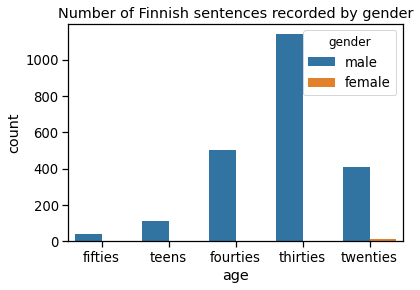

In [41]:
plot = sns.barplot(data=pd_dataframe_spark, x='age', y='count', hue='gender')
plot.set_title("Number of Finnish sentences recorded by gender")

plt.show(plot)

4. Visualiser l'évolution des phrases validées pour le genre masculin en fonction du groupe d'âge

In [105]:
# !!! groupBy().count()
up_votes = dataframe_spark.withColumn('up_total', fn.sum('up_votes').over(Window.partitionBy('age','gender')))  \
    .groupBy('age', 'gender', 'up_total').count() \
    .select('age', 'gender', 'up_total') \
    .where(" gender = 'male' ") 

up_votes.show()

+--------+------+--------+
|     age|gender|up_total|
+--------+------+--------+
|twenties|  male|     810|
|   teens|  male|     216|
|fourties|  male|     988|
| fifties|  male|      53|
|thirties|  male|    2190|
+--------+------+--------+



In [111]:
window = Window.partitionBy('gender').orderBy(up_votes.up_total.desc())
up_votes_classment = up_votes.withColumn('rank', fn.dense_rank().over(window)) \
    .select('age','gender','up_total','rank') \
    
up_votes_classment.show()

+--------+------+--------+----+
|     age|gender|up_total|rank|
+--------+------+--------+----+
|thirties|  male|    2190|   1|
|fourties|  male|     988|   2|
|twenties|  male|     810|   3|
|   teens|  male|     216|   4|
| fifties|  male|      53|   5|
+--------+------+--------+----+



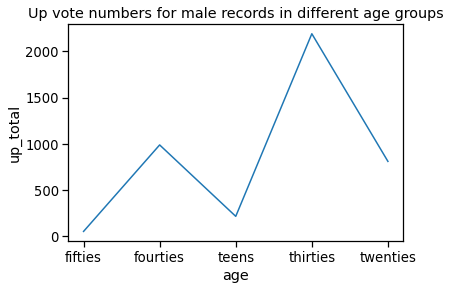

In [43]:
pd_frame = up_votes.toPandas()
plot_vote = sns.lineplot(data=pd_frame,x='age', y='up_total')
plot_vote.set_title('Up vote numbers for male records in different age groups')
plt.show(plot_vote)

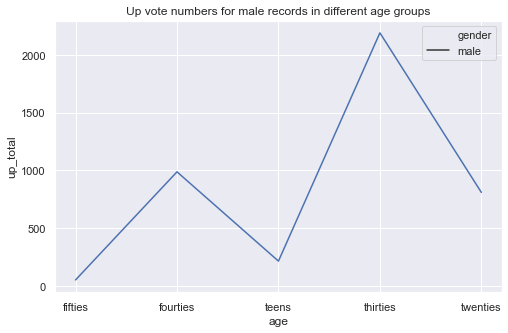

In [97]:
# par seaborn
sns.set(rc={'figure.figsize':(8,5)}, style='darkgrid')
chart = sns.lineplot(data=pd_frame, x='age', y='up_total', style='gender')
chart.set_title('Up vote numbers for male records in different age groups')
plt.show(chart)

5. Quelles phrases doivent être relues ?

In [99]:
down_votes = dataframe_spark.withColumn('sum_down_votes', fn.sum('down_votes').over(Window.partitionBy('sentence'))) \
    .select('sentence', 'down_votes', 'sum_down_votes') \
    .distinct()

down = down_votes.orderBy(down_votes.sum_down_votes.desc())
down.show(10)

+--------------------+----------+--------------+
|            sentence|down_votes|sum_down_votes|
+--------------------+----------+--------------+
|Ehkä se ei ollutk...|         1|             2|
|Jos ihmiset tietä...|         2|             2|
|"""No meehä Hydru...|         2|             2|
|       Mistä syystä?|         1|             2|
|Voisivatko asiat ...|         2|             2|
|Samoin tunteet ja...|         2|             2|
|Kun Uffe kävi läp...|         2|             2|
|Saara teristää ko...|         1|             2|
|Kaikilla arkin as...|         2|             2|
|Äänestimme kuiten...|         1|             2|
+--------------------+----------+--------------+
only showing top 10 rows

